# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.6.0-mu.new.57.72.167.176.191.fix.120.155.157.163.164.165.174.188.prep'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
177591,2020-08-12,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177592,2020-08-13,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177593,2020-08-14,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177594,2020-08-15,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177595,2020-08-16,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
177591,2020-08-12,Colombia,Vichada,6,4,0,2
177592,2020-08-13,Colombia,Vichada,6,4,0,2
177593,2020-08-14,Colombia,Vichada,6,1,0,5
177594,2020-08-15,Colombia,Vichada,6,1,0,5
177595,2020-08-16,Colombia,Vichada,6,1,0,5


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
210,2020-08-12,16474,3918,336,12220
211,2020-08-13,16680,3816,338,12526
212,2020-08-14,17069,3883,338,12848
213,2020-08-15,17454,3842,338,13274
214,2020-08-16,17714,4102,338,13274


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-08-12,20620110,7111608,751217,12757285,0.018216,0.309341,0.055611
2020-08-13,20931110,7254855,760927,12915328,0.018177,0.308520,0.055639
2020-08-14,21145784,7174008,766032,13205744,0.018113,0.312255,0.054827
2020-08-15,21435016,7303354,771966,13359696,0.018007,0.311633,0.054627
2020-08-16,21435738,7342919,771970,13320849,0.018007,0.310716,0.054778


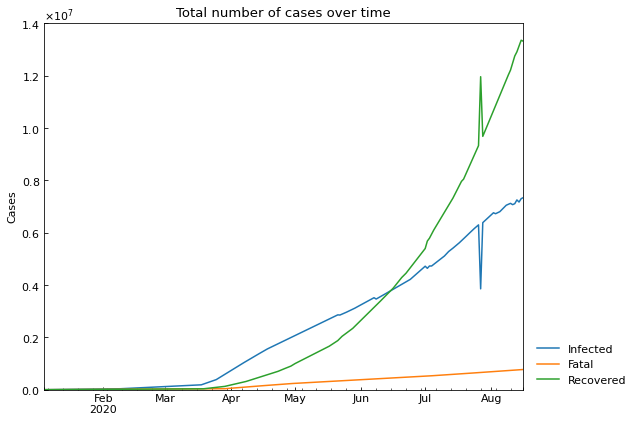

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
221,2020-08-12,51360,15420,1065,34875
222,2020-08-13,52534,15344,1076,36114
223,2020-08-14,53894,15338,1085,37471
224,2020-08-15,55121,15128,1092,38901
225,2020-08-16,55836,54740,1096,38438


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
183,2020-08-12,50210,14263,1059,34888
184,2020-08-13,51147,13950,1063,36134
185,2020-08-14,52217,13665,1073,37479
186,2020-08-15,53577,13547,1085,38945
187,2020-08-16,54714,13546,1088,40080


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
177591,2020-08-12,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177592,2020-08-13,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177593,2020-08-14,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177594,2020-08-15,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177595,2020-08-16,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
174151,COL,Colombia,Vichada,2020-08-12,107808
174152,COL,Colombia,Vichada,2020-08-13,107808
174153,COL,Colombia,Vichada,2020-08-14,107808
174154,COL,Colombia,Vichada,2020-08-15,107808
174155,COL,Colombia,Vichada,2020-08-16,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
177591,2020-08-12,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177592,2020-08-13,6,2,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177593,2020-08-14,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177594,2020-08-15,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
177595,2020-08-16,6,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
177591,2020-08-12,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
177592,2020-08-13,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
177593,2020-08-14,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
177594,2020-08-15,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
177595,2020-08-16,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
221,2020-08-12,1,1,1,0,0,1,1,3,2,2,1,30.56
222,2020-08-13,1,1,1,0,0,1,1,3,2,2,1,30.56
223,2020-08-14,1,1,1,0,0,1,1,3,2,2,1,30.56
224,2020-08-15,1,1,1,0,0,1,1,3,2,2,1,30.56
225,2020-08-16,1,1,1,0,0,1,1,3,2,2,1,30.56


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
221,2020-08-12,1,1,1,0,0,1,1,3,2,2,1,30.56
222,2020-08-13,1,1,1,0,0,1,1,3,2,2,1,30.56
223,2020-08-14,1,1,1,0,0,1,1,3,2,2,1,30.56
224,2020-08-15,1,1,1,0,0,1,1,3,2,2,1,30.56
225,2020-08-16,1,1,1,0,0,1,1,3,2,2,1,30.56


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

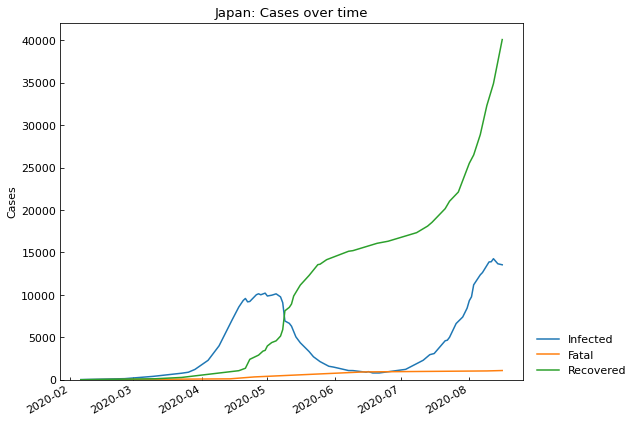

,Date,Confirmed,Infected,Fatal,Recovered
183,2020-08-12,50210,14263,1059,34888
184,2020-08-13,51147,13950,1063,36134
185,2020-08-14,52217,13665,1073,37479
186,2020-08-15,53577,13547,1085,38945
187,2020-08-16,54714,13546,1088,40080


In [26]:
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

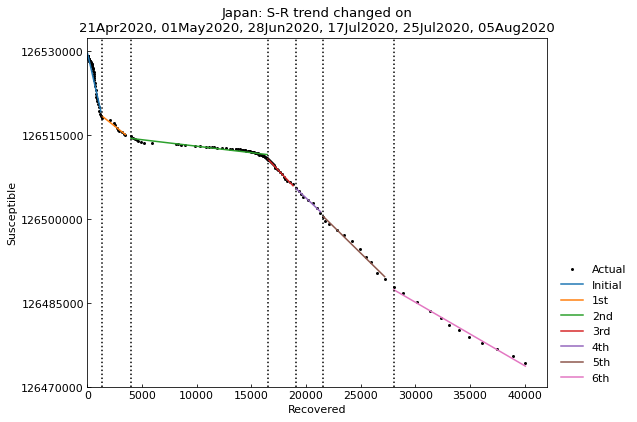

,Type,Start,End,Population
1st,Past,21Apr2020,30Apr2020,126529100
2nd,Past,01May2020,27Jun2020,126529100
3rd,Past,28Jun2020,16Jul2020,126529100
4th,Past,17Jul2020,24Jul2020,126529100
5th,Past,25Jul2020,04Aug2020,126529100
6th,Past,05Aug2020,16Aug2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	6th phase (05Aug2020 - 16Aug2020): finished  437 trials in 0 min 15 sec

	4th phase (17Jul2020 - 24Jul2020): finished  895 trials in 0 min 30 sec

	1st phase (21Apr2020 - 30Apr2020): finished 1643 trials in 1 min  0 sec

	3rd phase (28Jun2020 - 16Jul2020): finished 1567 trials in 1 min  0 sec

	2nd phase (01May2020 - 27Jun2020): finished 1397 trials in 1 min  0 sec

	5th phase (25Jul2020 - 04Aug2020): finished 1853 trials in 1 min  0 sec

Completed optimization. Total: 1 min 46 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
1st,Past,21Apr2020,30Apr2020,126529100,SIR-F,1.36,0.041553,0.000050,0.001131,0.000744,45,0.042,622,42,27,0.134275,1643,1 min 0 sec
2nd,Past,01May2020,27Jun2020,126529100,SIR-F,0.29,0.062003,0.000063,0.000753,0.002382,45,0.062,495,13,41,0.464706,1397,1 min 0 sec
3rd,Past,28Jun2020,16Jul2020,126529100,SIR-F,2.05,0.001267,0.000001,0.004401,0.002144,45,0.001,21738,14,7,0.046505,1567,1 min 0 sec
4th,Past,17Jul2020,24Jul2020,126529100,SIR-F,2.18,0.000994,0.000004,0.004213,0.001930,45,0.001,8539,16,7,0.020737,895,0 min 30 sec
5th,Past,25Jul2020,04Aug2020,126529100,SIR-F,2.02,0.001267,0.000001,0.003737,0.001843,45,0.001,21742,16,8,0.032928,1853,1 min 0 sec
6th,Past,05Aug2020,16Aug2020,126529100,SIR-F,1.16,0.000107,0.000009,0.003109,0.002670,45,0.000,3319,11,10,0.033273,437,0 min 15 sec


### Accuracy of estimation

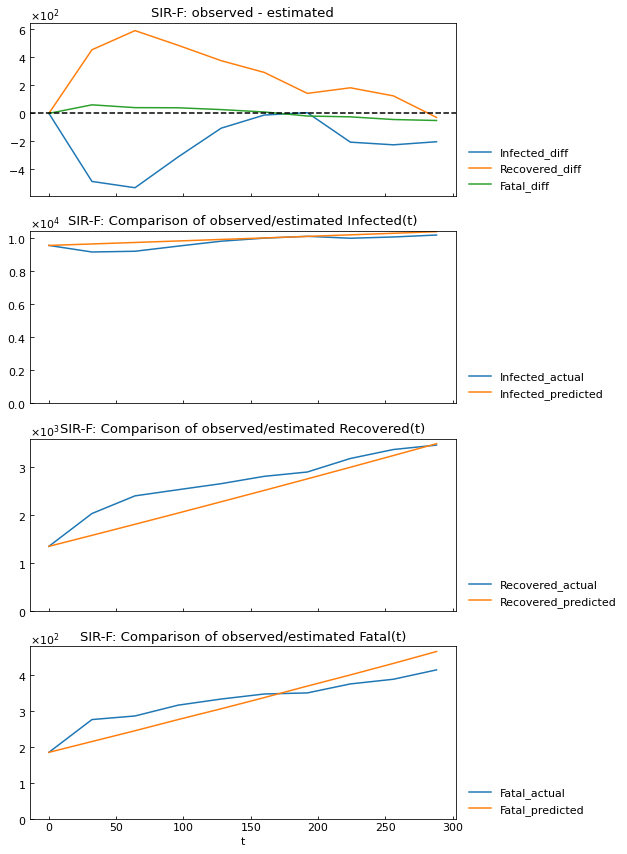

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

2.18

### Show parameter history

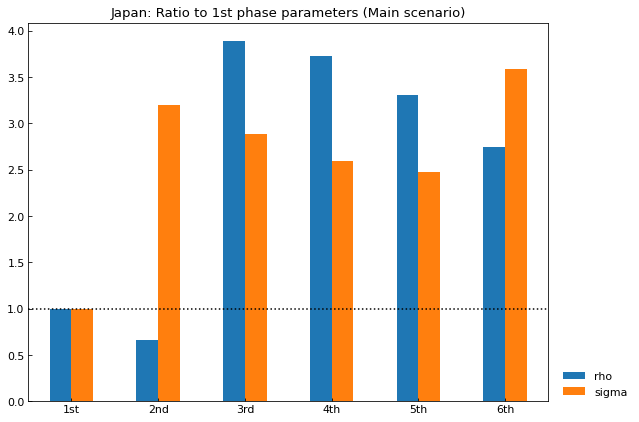

,1st,2nd,3rd,4th,5th,6th
rho,1.0,0.666396,3.893161,3.726253,3.305692,2.749896
sigma,1.0,3.202613,2.882672,2.594845,2.477975,3.590464


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

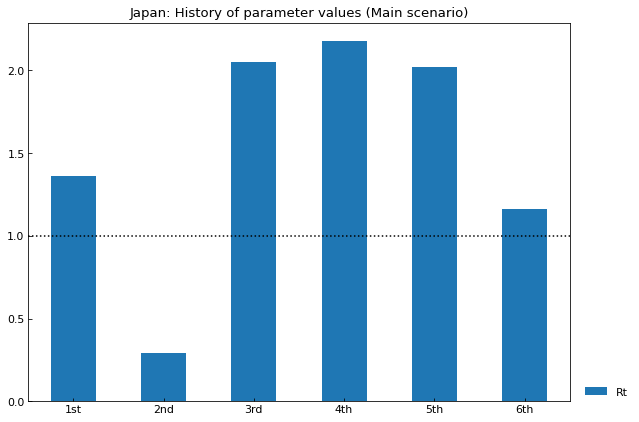

,1st,2nd,3rd,4th,5th,6th
Rt,1.36,0.29,2.05,2.18,2.02,1.16


In [33]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

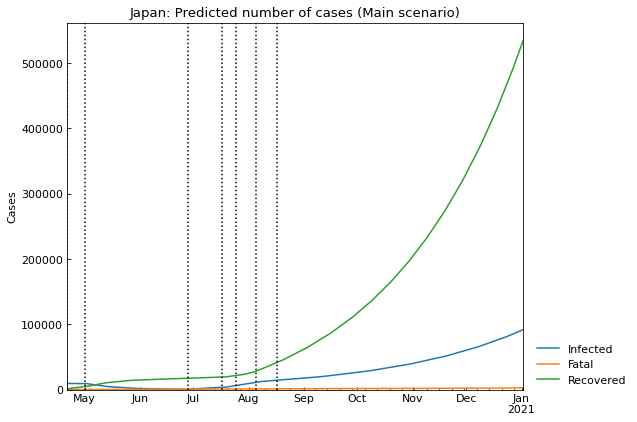

,Date,Confirmed,Fatal,Infected,Recovered
252,2020-12-29,594428,2761,87187,504480
253,2020-12-30,603118,2788,88350,511980
254,2020-12-31,611924,2816,89528,519580
255,2021-01-01,620847,2844,90721,527282
256,2021-01-02,629888,2873,91929,535086


In [34]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [35]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.002670418944475979

In [36]:
sigma_new = sigma_current * 2
sigma_new

0.005340837888951958

In [37]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     1st      Past  21Apr2020  30Apr2020   126529100  SIR-F  1.36   
         2nd      Past  01May2020  27Jun2020   126529100  SIR-F  0.29   
         3rd      Past  28Jun2020  16Jul2020   126529100  SIR-F  2.05   
         4th      Past  17Jul2020  24Jul2020   126529100  SIR-F  2.18   
         5th      Past  25Jul2020  04Aug2020   126529100  SIR-F  2.02   
         6th      Past  05Aug2020  16Aug2020   126529100  SIR-F  1.16   
         7th    Future  17Aug2020  01Jan2021   126529100  SIR-F  1.16   
Medicine 1st      Past  21Apr2020  30Apr2020   126529100  SIR-F  1.36   
         2nd      Past  01May2020  27Jun2020   126529100  SIR-F  0.29   
         3rd      Past  28Jun2020  16Jul2020   126529100  SIR-F  2.05   
         4th      Past  17Jul2020  24Jul2020   126529100  SIR-F  2.18   
         5th      Past  25Jul2020  04Aug2020   126529100  SIR-F  2.02   
         6th      Past  05Aug2020  16Aug2020   126529100  SIR-F  1.16   
         7th    Future  17Aug2020  16Sep2020   126529100  SIR-F  1.16   
         8th    Future  17Sep2020  01Jan2021   126529100  SIR-F  0.58   

                   theta     kappa       rho     sigma  tau  alpha1 [-]  \
Scenario Phase                                                            
Main     1st    0.041553  0.000050  0.001131  0.000744   45       0.042   
         2nd    0.062003  0.000063  0.000753  0.002382   45       0.062   
         3rd    0.001267  0.000001  0.004401  0.002144   45       0.001   
         4th    0.000994  0.000004  0.004213  0.001930   45       0.001   
         5th    0.001267  0.000001  0.003737  0.001843   45       0.001   
         6th    0.000107  0.000009  0.003109  0.002670   45       0.000   
         7th    0.000107  0.000009  0.003109  0.002670   45       0.000   
Medicine 1st    0.041553  0.000050  0.001131  0.000744   45       0.042   
         2nd    0.062003  0.000063  0.000753  0.002382   45       0.062   
         3rd    0.001267  0.000001  0.004401  0.002144   45       0.001   
         4th    0.000994  0.000004  0.004213  0.001930   45       0.001   
         5th    0.001267  0.000001  0.003737  0.001843   45       0.001   
         6th    0.000107  0.000009  0.003109  0.002670   45       0.000   
         7th    0.000107  0.000009  0.003109  0.002670   45       0.000   
         8th    0.000107  0.000009  0.003109  0.005341   45       0.000   

                1/alpha2 [day]  1/gamma [day]  1/beta [day]      RMSLE Trials  \
Scenario Phase                                                                  
Main     1st               622             42            27   0.134275   1643   
         2nd               495             13            41   0.464706   1397   
         3rd             21738             14             7  0.0465049   1567   
         4th              8539             16             7  0.0207373    895   
         5th             21742             16             8  0.0329281   1853   
         6th              3319             11            10  0.0332726    437   
         7th              3319             11            10          -      -   
Medicine 1st               622             42            27   0.134275   1643   
         2nd               495             13            41   0.464706   1397   
         3rd             21738             14             7  0.0465049   1567   
         4th              8539             16             7  0.0207373    895   
         5th             21742             16             8  0.0329281   1853   
         6th              3319             11            10  0.0332726    437   
         7th              3319             11            10          -      -   
         8th              3319              5            10          -      -   

                     Runtime  
Scenario Phase                
Main     1st    1 min  0 sec  
         2nd    1 min  0 sec 

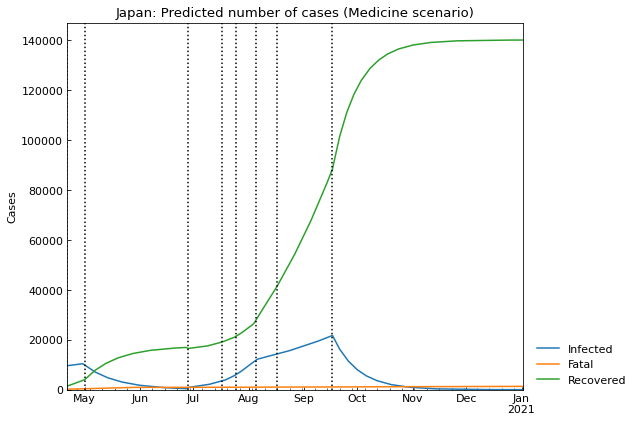

,Date,Confirmed,Fatal,Infected,Recovered
252,2020-12-29,141472,1336,13,140123
253,2020-12-30,141473,1336,12,140125
254,2020-12-31,141475,1336,12,140127
255,2021-01-01,141476,1336,11,140129
256,2021-01-02,141477,1336,10,140131


In [38]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [39]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,8th_Rt
Main,91929,02Jan2021,91929,2873,-
Medicine,21736,17Sep2020,10,1336,0.58
